# Installs & Imports

In [1]:
!python --version # requires 3.8+

Python 3.8.0


In [2]:
!pip install -q wget chess seaborn numpy pandas

In [3]:
import wget, chess, bz2, time
from chess import pgn
from pathlib import Path
import seaborn as sns
sns.set_theme(style="whitegrid")
import numpy as np
import pandas as pd
from collections import defaultdict, Counter, namedtuple
from pprint import pprint
import matplotlib.pyplot as plt

# Classes & Functions

## Data

In [4]:
def download(url, filename, overwrite=False):
    
    if '.pgn' not in filename:
        filename += '.pgn'
        pgn_filename = filename
    else:
        if not filename.endswith('.pgn'):
            idx = filename.find('.pgn') + 4
            pgn_filename = filename[:idx]
        else:
            pgn_filename = filename
            
    filename = Path(filename)
    if not filename.exists() or overwrite:
        print(f'Downloading {str(filename)} from {url}')
        filename = wget.download(str(url), str(filename))
        if filename.endswith('.bz2'):
            filename = bunzip(filename)
    else:
        print(f'{str(filename)} already exists. Pass in `overwrite=True` to overwrite it.')
        
    return pgn_filename

def bunzip(filename):
    zipped_filename = Path(filename)
    unzipped_filename = zipped_filename.with_suffix('')
    with open(unzipped_filename, 'wb') as f_out:
        with bz2.open(zipped_filename, 'rb') as f_in:
            f_out.write(f_in.read())
            print(f"Wrote {str(unzipped_filename)}")
            return unzipped_filename

def get_avg_elo(game):
    if not game.headers['WhiteElo'].endswith('?') \
                and not game.headers['BlackElo'].endswith('?'):
        avg_elo = (int(game.headers['WhiteElo']) + int(game.headers['BlackElo'])) / 2
        return avg_elo
    else:
        return None

def get_moves(game):
    return [move.san() for move in game.mainline()]

def get_moves_generator(game):
    for move in game.mainline():
        yield move.san()

def games_generator_from_file(filename,
                              max_games=None,
                              sample=1.0):
    pgn_file = open(filename)
    count = 0
    game = pgn.read_game(pgn_file)
    while game:
        if np.random.random() < 0.1:
            game_dict = dict(game.headers)
            game_dict['moves'] = get_moves(game)
            if date := game_dict.get('UTCDate', None):
                year, month, day = date.split('.')
                game_dict['year'] = int(year)
                game_dict['month'] = int(month)
                game_dict['day'] = int(day)
            game_dict['avg_elo'] = get_avg_elo(game)
            yield game_dict
            count += 1

            if max_games and count >= max_games:
                break
        
        game = pgn.read_game(pgn_file)

def filter_games(games,
                 white=None,
                 black=None,
                 min_elo=0,
                 max_elo=4000,
                 require_elo=False,
                 time_control=None):
    filtered = []
    for game in games:
        valid = True
        if white and game['White'] != white:
            valid = False
        elif black and game['Black'] != black:
            valid = False
        elif require_elo and not (min_elo < int(game['WhiteElo']) < max_elo):
            valid = False
        elif require_elo and not (min_elo < int(game['BlackElo']) < max_elo):
            valid = False
        elif time_control and game['TimeControl'] != time_control:
            valid = False
        if valid:
            filtered.append(game)
    return filtered

def filter_trie(trie, **kwargs):
    new_trie = {}
    
    for move, sub_trie in trie.items():
        if move == None:
            new_trie[None] = filter_games(sub_trie, **kwargs)
        else:
            new_trie[move] = filter_trie(sub_trie, **kwargs)
    return new_trie

## Utilities

In [5]:
def sanitize_url(url):
    return Path(url).name.translate(dict.fromkeys(map(ord, '?='), '_'))

def round_nearest(x, n):
    return np.round(np.array(x) / n).astype(int) * n

def time_profile(fn):
    def new_fn(*args, **kwargs):
        start_t = time.time()
        ret = fn(*args, **kwargs)
        end_t = time.time()
        print(f'{fn.__name__} took {end_t - start_t:.2f}s')
        return ret
    return new_fn

## Trie

In [6]:
@time_profile
def make_game_trie(games, root=None):
    root = root or dict()
    for game in games:
        current_dict = root
        for move in game['moves']:
            current_dict = current_dict.setdefault(move, {})
        if None not in current_dict:
            current_dict[None] = []
        current_dict[None].append(game)
    return root

def in_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return False
        current_dict = current_dict[move]
    return True

def get_sub_trie(trie, moves):
    current_dict = trie
    for move in moves:
        if move not in current_dict:
            return None
        current_dict = current_dict[move]
    return current_dict

def count_trie(trie):
    count = 0
    for move, sub_trie in trie.items():
        if not isinstance(sub_trie, dict):
            leaves = sub_trie  # leaves are games
            count += len(leaves)
        else:
            count += count_trie(sub_trie)
    return count

def get_leaves(trie):
    leaves = []
    if isinstance(trie, list):
        for game in trie:
            yield game
    elif isinstance(trie, dict):
        for move, sub_trie in trie.items():
            for game in get_leaves(sub_trie):
                yield game

## Statistics

In [7]:
def get_move_to_games_mapping(trie, elo_min=0, elo_max=float('inf')):
    move_to_games = {}
    
    for move, sub_trie in trie.items():
        games = list(get_leaves(sub_trie))
        move_to_games[move] = games
        
    return move_to_games

def build_move_df(trie, **kwargs):
    data = []
    move_to_games = get_move_to_games_mapping(trie, *kwargs)
    for move, games in move_to_games.items():
        for game in games:
            game = game.copy()
            game['move'] = move
            data.append(game)

    move_df = pd.DataFrame(data)
    return move_df

def get_elo_to_move_mapping(trie, bin_width=200):
    elo_to_move = defaultdict(list)

    for move, sub_trie in trie.items():
        for game in get_leaves(sub_trie):
            elo = game['avg_elo']
            rounded_elo = round_nearest(elo, bin_width)
            elo_to_move[rounded_elo].append(move)
            
    return elo_to_move

def get_elo_move_count_df(move_df, bin_width=400):
    move_df = move_df.copy()
    move_df['avg_elo'] = round_nearest(move_df['avg_elo'], bin_width)
    group_df = move_df.groupby(['avg_elo', 'move']).size().reset_index().rename(columns={0: 'count'})
    return pd.crosstab(group_df.avg_elo, group_df.move, group_df['count'], aggfunc=sum).fillna(0)

def normalize(d, target=1.0):
    raw = sum(d.values())
    factor = target / raw
    return {key:value*factor for key,value in d.items()}


# Below = outdated(?)

## Visualization

In [171]:
import matplotlib.ticker as ticker

def plot_move_count_by_elo(move_df, bin_width=100, normalize_=False, figsize=(8, 5)):
    count_df = get_elo_move_count_df(move_df)
    
    stat = 'count'
    if normalize_:
        stat = 'frequency'
        for elo in count_df.columns:
            sum_ = sum(count_df[elo].values)
            count_df[elo] = count_df[elo] / sum_
        count_df = count_df.rename(columns={'count': 'frequency'})
        
    count_df['move'] = count_df.index
    melted_df = pd.melt(count_df, id_vars="move", var_name="elo", value_name=stat)
    g = sns.catplot(x='elo',
                    y=stat,
                    hue='move',
                    kind='bar',
                    legend=True,
                    data=melted_df)
    return g
    
def plot_move_distribution_by_elo(move_df, bin_width=100, figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    g = sns.histplot(ax=ax,
                     x='avg_elo',
                     y=None,
                     hue='move',
                     binwidth=bin_width,
                     stat='count',
                     multiple='fill',
                     legend=True,
                     data=move_df)
    return fig
    
def plot_move_distribution_by_year(move_df, bin_width=1, figsize=(8, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    
    move_df = move_df.copy()
    move_df['year_month'] = round_nearest(move_df['year'].values + (move_df['month'].values / 12).astype(int), bin_width)
    g = sns.histplot(ax=ax,
                     x='year_month',
                     y=None,
                     hue='move',
                     binwidth=bin_width,
                     stat='count',
                     multiple='fill',
                     legend=True,
                     data=move_df)
    g.get_xaxis().set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:g}'))
    return fig

# Run

In [219]:
#URL = 'https://lichess.org/games/export/seaghost27?max=100'
#URL = 'https://lichess.org/games/export/DrNykterstein?max=7000'
#URL = 'https://database.lichess.org/standard/lichess_db_standard_rated_2015-02.pgn.bz2'
URL = None
FILENAME = 'chess365_d35.pgn'

if URL:    
    filename = sanitize_url(URL)
    pgn_filename = download(URL, filename)
    
else:
    pgn_filename = FILENAME
    
print(pgn_filename)

chess365_d35.pgn


In [220]:
games_gen = games_generator_from_file(pgn_filename)
trie = make_game_trie(games_gen)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xdc in position 1908: invalid continuation byte

In [32]:
print(count_trie(trie))

1000


In [216]:
#LINE = ['e4', 'c5', 'Nf3', 'Nc6', 'd4', 'cxd4', 'Nxd4', ]  # open sicilian
LINE = ['d4', 'd5', 'c4', 'e6', 'Nc3', 'Nf6']  # 

line_trie = get_sub_trie(trie, LINE)
move_df = build_move_df(line_trie)

In [217]:
move_df.head()

,Event,Site,Date,Round,White,Black,Result,BlackElo,BlackRatingDiff,ECO,...,UTCDate,UTCTime,WhiteElo,WhiteRatingDiff,moves,year,month,day,avg_elo,move
0,Rated Blitz game,https://lichess.org/qBwMHOb3,????.??.??,?,GOVLAMIX3,mime45,1-0,1766,-12,D37,...,2015.01.31,23:35:08,1709,+13,"[d4, d5, c4, e6, Nc3, Nf6, Nf3, Bd6, e3, c6, a...",2015,1,31,1737.5,Nf3
1,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/bUhvUYci,????.??.??,?,raiken2,stevehayman,1-0,1243,-1,D55,...,2015.01.31,23:36:28,1981,+0,"[d4, d5, c4, e6, Nc3, Nf6, Nf3, Be7, Bg5, O-O,...",2015,1,31,1612.0,Nf3
2,Rated Blitz tournament https://lichess.org/tou...,https://lichess.org/afArY5hh,????.??.??,?,raiken2,boniclay,0-1,1628,+22,D43,...,2015.02.01,00:11:28,1962,-22,"[d4, d5, c4, e6, Nc3, Nf6, Nf3, c6, Bg5, Nbd7,...",2015,2,1,1795.0,Nf3
3,Rated Blitz game,https://lichess.org/NrnPYGas,????.??.??,?,GustavoTorres,branko,0-1,1935,+12,D53,...,2015.02.01,05:12:42,1959,-11,"[d4, d5, c4, e6, Nc3, Nf6, Bg5, Be7, Bxf6, Bxf...",2015,2,1,1947.0,Bg5


## Move counts at different ELOs

In [105]:
#next(get_leaves(filter_trie(line_trie, white='DrNykterstein')))

StopIteration: 

### Top Move Distributions Across ELO and Year

In [ ]:
N = 5
ELO_BIN_WIDTH = 400

In [71]:
top_moves = move_df['move'].value_counts().iloc[:N].index.values.tolist()
print(top_moves)

top_moves_df = move_df[move_df['move'].isin(top_moves)]

['e4', 'd4', 'Nf3', 'g3', 'e3']


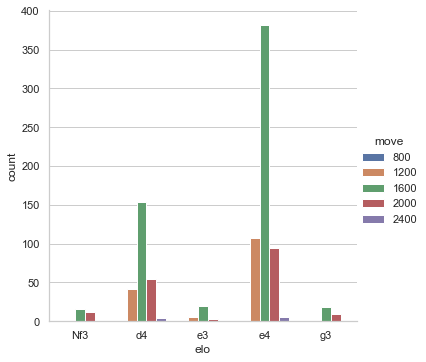

In [176]:
move_count_plot = plot_move_count_by_elo(top_moves_df,
                                         bin_width=ELO_BIN_WIDTH)

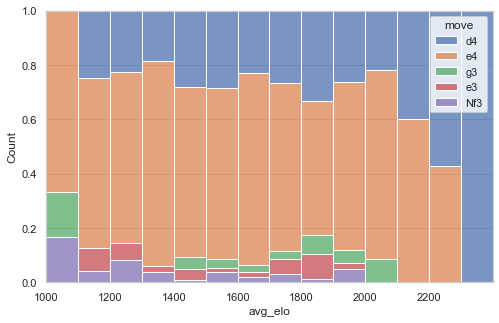

In [18]:
distr_by_elo = plot_move_distribution_by_elo(top_moves_df, 100)

In [175]:
if top_moves_df['year'].nunique() > 1:
    distr_by_year = plot_move_distribution_by_year(top_moves_df, 0.75)

In [213]:
from collections import namedtuple
Line = namedtuple('Line', ['depth', 'score', 'moves', 'freqs'])

def get_top_lines(trie, max_depth=6):
    move_df = build_move_df(trie)
    counts = move_df['move'].value_counts()
    frequencies = counts / len(move_df)
    
    lines = []
    for move, sub_trie in trie.items():
        
        if max_depth == 0 and move is not None:
            score = freq = frequencies[move]
            lines.append(Line(1, score, [move], [freq]))
        else:
            if isinstance(sub_trie, dict):
                top_sub_lines = get_top_lines(sub_trie, max_depth=max_depth-1)
                for _, score, sub_line, freqs in top_sub_lines:
                    freq = frequencies[move]
                    score = score * freq
                    lines.append(Line(len(sub_line)+1, score, [move] + sub_line, [freq] + freqs))
            elif move is None and isinstance(sub_trie, list):
                lines.append(Line(0, 1, [], []))
                
    return sorted(lines, reverse=True)
    

In [214]:
get_top_lines(line_trie, max_depth=3)[:10]

[Line(depth=4, score=0.06399999999999999, moves=['e4', 'e5', 'Nf3', 'Nc6'], freqs=[0.591, 0.3333333333333333, 0.5786802030456852, 0.5614035087719298]),
 Line(depth=4, score=0.029999999999999995, moves=['e4', 'd5', 'exd5', 'Qxd5'], freqs=[0.591, 0.07952622673434856, 0.7446808510638298, 0.8571428571428571]),
 Line(depth=4, score=0.026999999999999996, moves=['e4', 'c5', 'Nf3', 'd6'], freqs=[0.591, 0.23519458544839256, 0.45323741007194246, 0.42857142857142855]),
 Line(depth=4, score=0.023, moves=['e4', 'c5', 'Nf3', 'Nc6'], freqs=[0.591, 0.23519458544839256, 0.45323741007194246, 0.36507936507936506]),
 Line(depth=4, score=0.022999999999999996, moves=['e4', 'e5', 'Nf3', 'd6'], freqs=[0.591, 0.3333333333333333, 0.5786802030456852, 0.20175438596491227]),
 Line(depth=4, score=0.02, moves=['e4', 'e6', 'd4', 'd5'], freqs=[0.591, 0.14213197969543148, 0.47619047619047616, 0.5]),
 Line(depth=4, score=0.016000000000000004, moves=['d4', 'Nf6', 'c4', 'e6'], freqs=[0.254, 0.23622047244094488, 0.55, 0.48

In [79]:
frequencies

e4     0.35
d4     0.34
Nf3    0.12
c4     0.09
b3     0.03
e3     0.02
Nc3    0.02
d3     0.01
Nh3    0.01
g3     0.01
Name: move, dtype: float64